#### Purpose of the notebook
To use machine learning to answer the following questions:
- What features have predictive power to the housing price movement?
- What is the potential return and variability if using machine learning approach to help investment in housing?
- Is machine learning model perform better comparing to the baseline model?

#### Feature Engineering 
- To check and drop all the missing data 
- To check what feature is useless 
- To create `time` variable (combine year with quarter)
- To create the lag varaible(use last quarter variable as features)

In [1]:
# import all the library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
sns.set_theme(context='notebook', style='whitegrid', palette='pastel')

In [3]:
origin = pd.read_csv("integrated_housing_data.csv")

In [4]:
origin.shape

(7705, 20)

In [5]:
# How many missing data are here 
for col in origin.columns:
    print(f"{col} {origin[col].isna().sum()} ")

location 0 
year 0 
quarter 0 
nominal_price 1139 
price_to_income 2237 
price_to_rent 1889 
rent 1165 
employment_in_service 3531 
exchange_rate 626 
gpd_growth_rate 810 
gdp_per_capital 677 
inflation 666 
short_interest_rate 2228 
long_interest_rate 2530 
ppp 673 
share_price 1390 
working_age_popu 606 
broad_money 3813 
urban_percent 810 
real_price 1139 


In [6]:
origin = origin.copy(deep=False)
origin["quarter"] = origin.quarter.apply(lambda str1: int(str1[-1]))
origin["time"] = pd.PeriodIndex(year = origin.year, quarter = origin.quarter)

- In this analysis, we use real price rate of change as a target variable, because in the analysis our interest is to determine which country is the best place to invest, we need to determine the potential return for the investment and its variability for different countries

- Also, we use rate of change for all the variables is because not only it have better predictive power on the target variable, but it also serve as a kind of normalization for the variables

In [7]:
# Create group for different country
group_dfs = {}
for gp in origin.groupby(by="location"):
    #print(gp[0])
    group_df = gp[1]
    group_df.index = group_df.time
    group_df = group_df.copy(deep = True)

    # Calculate rate of change for all variable
    for col in origin.columns :
        if col not in ["gpd_growth_rate", "location", "year", "quarter", "time"]:
            group_df[f"{col}_roc"] = group_df[col].diff()/group_df[col]

    # define shift columns
    shift_col = [col for col in group_df.columns if col not in ['location', 'year', 'quarter', "time"]]
    tmp = pd.DataFrame()
    for col in shift_col:
        for i in [1]:
            tmp = tmp.copy(deep=True)
            tmp[f"{col}_{i}"] = group_df[col].shift(i)
            
    # Assign target variable
    tmp[['location', 'year', 'quarter', "time"]] = group_df [['location', 'year', 'quarter', "time"]]
    tmp["real_price_roc"] = group_df["real_price_roc"]
    group_dfs[gp[0]] = tmp


In [8]:
df = pd.concat(group_dfs.values(), axis = 0)
# Drop all the missing value 
df = df.dropna().reset_index(drop=True)

In [9]:
df.columns

Index(['nominal_price_1', 'price_to_income_1', 'price_to_rent_1', 'rent_1',
       'employment_in_service_1', 'exchange_rate_1', 'gpd_growth_rate_1',
       'gdp_per_capital_1', 'inflation_1', 'short_interest_rate_1',
       'long_interest_rate_1', 'ppp_1', 'share_price_1', 'working_age_popu_1',
       'broad_money_1', 'urban_percent_1', 'real_price_1',
       'nominal_price_roc_1', 'price_to_income_roc_1', 'price_to_rent_roc_1',
       'rent_roc_1', 'employment_in_service_roc_1', 'exchange_rate_roc_1',
       'gdp_per_capital_roc_1', 'inflation_roc_1', 'short_interest_rate_roc_1',
       'long_interest_rate_roc_1', 'ppp_roc_1', 'share_price_roc_1',
       'working_age_popu_roc_1', 'broad_money_roc_1', 'urban_percent_roc_1',
       'real_price_roc_1', 'location', 'year', 'quarter', 'time',
       'real_price_roc'],
      dtype='object')

In [10]:
print(f"Before: {len(origin)}, After: {len(df)}")

Before: 7705, After: 1682


In [11]:
# How many record each yrs
df.year.value_counts().mean()

32.34615384615385

In [12]:
# How many decreasing 
len(df.real_price_roc[df.real_price_roc<0])

549

#### Model Building - Random Forest
- We use random forest and lasso regression to predict and understand the features

Reasons for random forest:
- Good performance 
- Avoid overfitting 
- Have inbuilt feature importance based on gini index 
- Little effort to tune the parameter 

Reasons for lasso regression:
- Easy to understand 
- Avoid overfitting 
- Can perform feature selection based on the coefficient

In [13]:
# Remove irrelevant columns 
useless_col = ["location", "year", "quarter", "time" ]
target = "real_price_roc"
use_col = [col for col in df.columns if col not in useless_col+[target] and "roc" in col ]

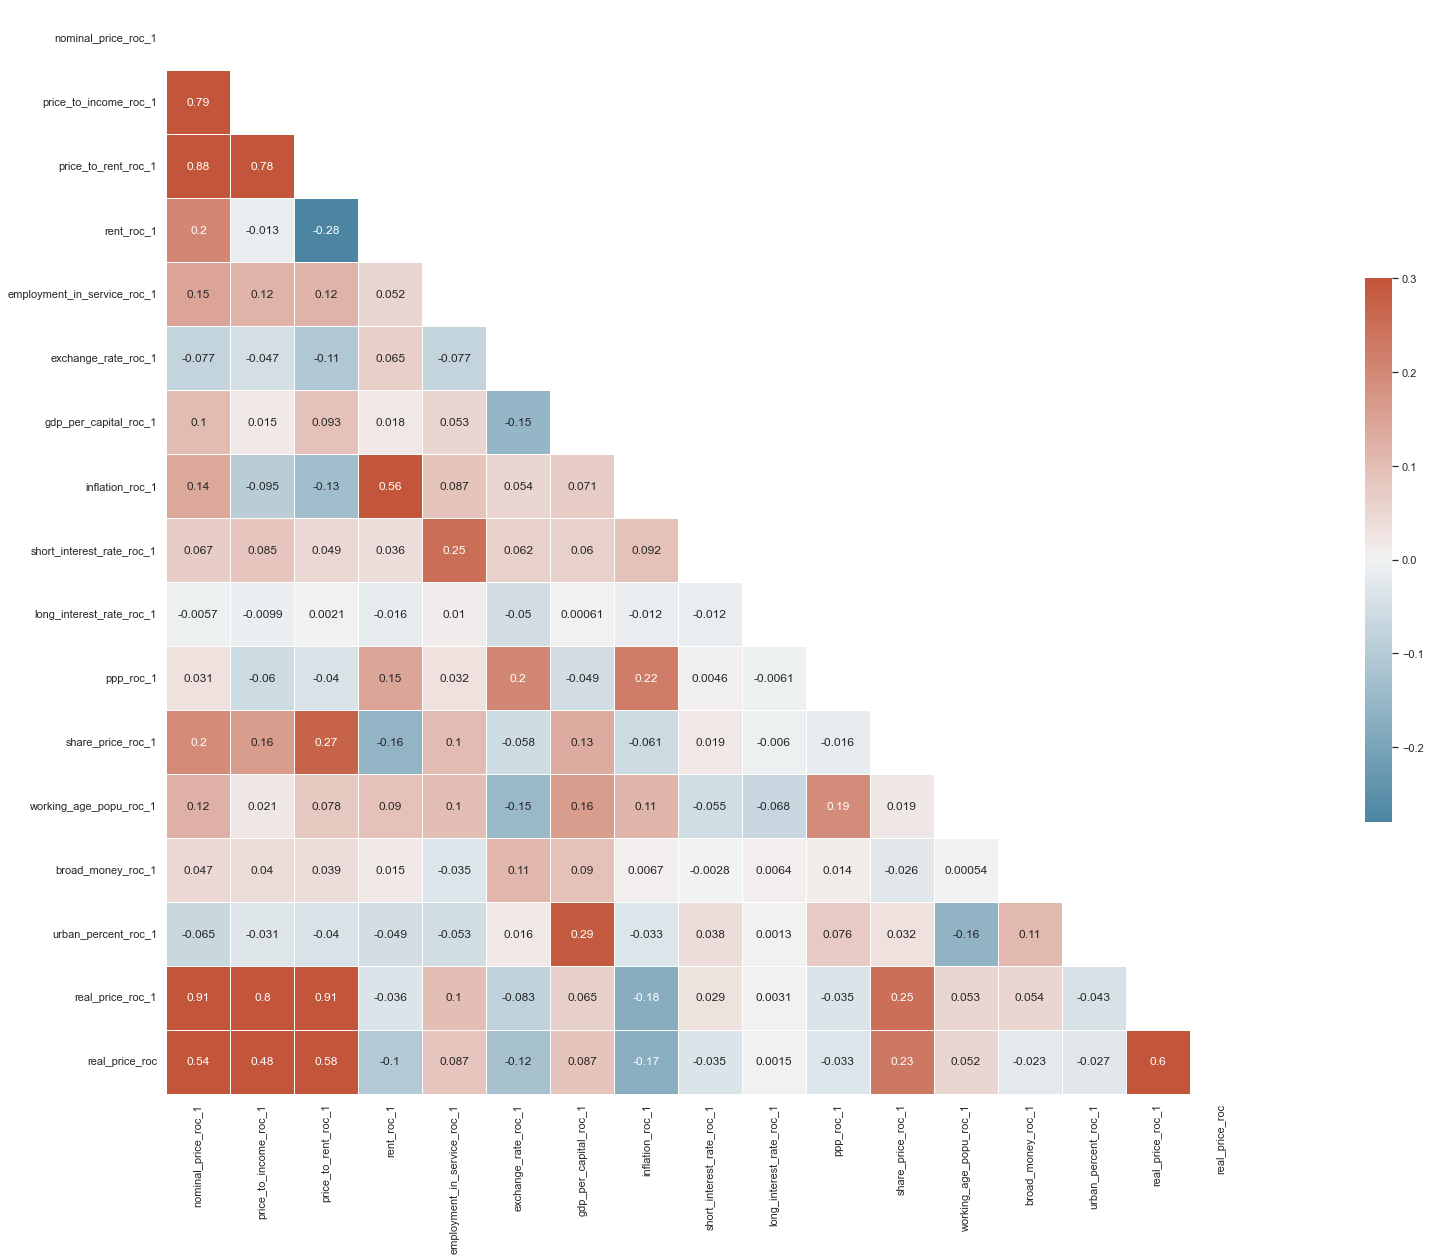

In [14]:
# Correlation Matrix
corr = df[use_col+[target]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

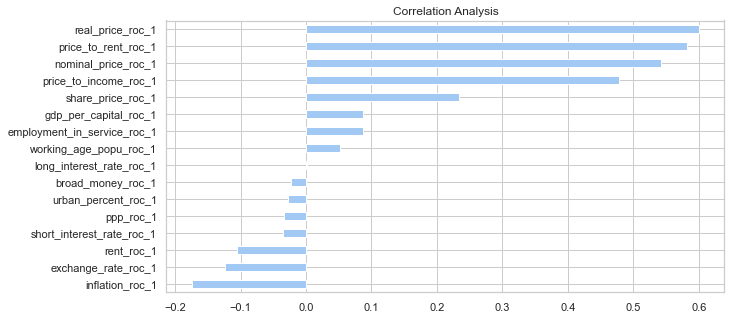

In [15]:
corr.iloc[-1, :-1].sort_values().plot(kind = "barh", figsize = (10, 5))
plt.title("Correlation Analysis")
plt.show()

- The above figure clearly show that `price_to_rent_roc_1`, `nominal_price_roc_1`, `price_to_income_roc_1`, `share_price_roc_1`, `inflation_roc_1` having high correlation to the target variable

In [30]:
def train_test_split(data, yr):
    mask = data.year > yr
    return data[~mask], data[mask]

def find_num_split(data, yr):
    """
    Find how many split we need to start prediction from 2012
    """
    test_start = (data.year <= yr).sum()
    n_split = len(data) -  test_start
    return int(n_split)

# Choose cut point to split?
# df.sort_values(by="time").iloc[:int(len(df)*.7), :]
# As 1971-2012 include about 70% of data, choose 2012 as a cut point
train, test = train_test_split(df, 2012)

In [32]:
find_num_split(df, 2012)

525

In [17]:
# Import sklearn library 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.feature_selection import SequentialFeatureSelector

In [18]:
def train_model_cv(model, X, y):
    """
    Train any kind of sklearn model using cross validation technique
    return all of the estimator , and prediction 
    """
    estimator = model
    cv_model = cross_validate(
        estimator,
        X,
        y,
        scoring="neg_mean_absolute_error",
        # One step prediction
        cv=TimeSeriesSplit(525, test_size=1),
        return_estimator=True,
        n_jobs=-1
    )
    
    y_pred = []
    y_test = []

    tmp = [list(t) for t in zip(*TimeSeriesSplit(525, test_size=1).split(X))]
    for _, testId, model in zip(tmp[0], tmp[1], cv_model["estimator"]):
        y_test.append(y.iloc[testId])
        y_pred.append(model.predict(X.iloc[testId])[0])

    return cv_model, y_test, y_pred


Cross Validation
- We use cross validation technique to evaluate the model to avoid overfitting
- To validate our model, we use walk-forward validation method to backtest our model as it can make our model more reboust(make use of all available data to make prediction) and ensure test set and train set are less dependent
- First, we choose certain size of data as base trainning data(in our case any data after 2012) and train the model
- Then, we evaluate our model using only the first test record 
- After that, we add the corresponding record into train set and retrain our model
- We will iterate the above process untill all of the test data are evaluated
- We have kept the data in temporal order and choose 2012 as a cut point as 1971-2012 include about 70% of data.

In [19]:
X_train, X_test = train[use_col].values, test[use_col].values
y_train, y_test = train[target].values, test[target].values.reshape((-1, 1))

# Model building 
model = RandomForestRegressor(n_estimators = 100)
cv_model_tree, y_test, y_pred = train_model_cv(model, df[use_col], df[target])

# Model evaluation 
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.010741465405335916
8.676753732508777
0.4341475056728832


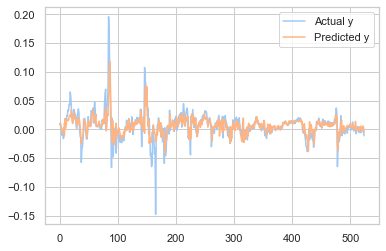

In [20]:
# Plot the prediction 
plt.clf()
plt.plot(y_test, label = "Actual y")
plt.plot(y_pred, label = "Predicted y")
plt.legend()
plt.show()

In [21]:
# Feature importances from random forest 
std = np.std([tree.feature_importances_  for tree in cv_model_tree["estimator"]], axis = 0)
imp = pd.DataFrame(
    data=np.mean([tree.feature_importances_  for tree in cv_model_tree["estimator"]], axis=0),
    columns=["Importances"],
    index=use_col
).sort_values(by="Importances")
imp["std"] = std


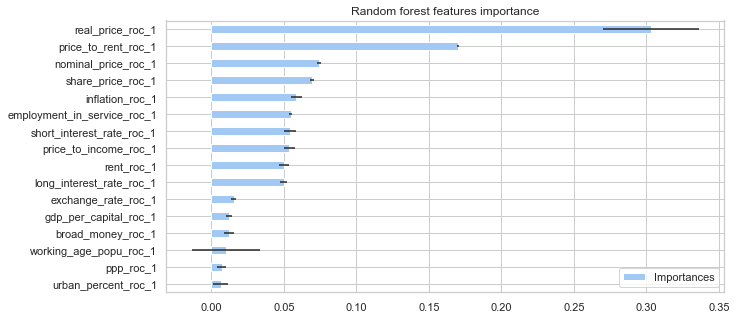

In [22]:
imp.plot(kind = "barh", y = "Importances", xerr = "std", figsize = (10, 5))
plt.title("Random forest features importance")
plt.show()

- The above figure clearly show that `price_to_rent_roc_1`, `nominal_price_roc_1`, `share_price_roc_1`, `inflation_roc_1` having high correlation to the target variable

#### Lasso Regression

In [23]:
# Model building 
model = Lasso(alpha=1e-5, max_iter = 3000)
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)

cv_model, y_test, y_pred = train_model_cv(model, df[use_col], df[target])


In [24]:
# Model evaluation 
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.01059609870361421
8.296254233199052
0.43124461099455835


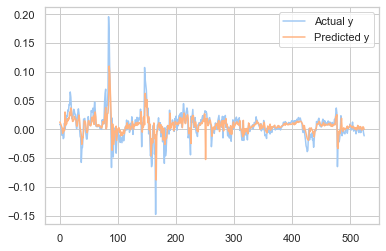

In [25]:
# Plot the prediction 
plt.clf()
plt.plot(y_test, label = "Actual y")
plt.plot(y_pred, label = "Predicted y")
plt.legend()
plt.show()

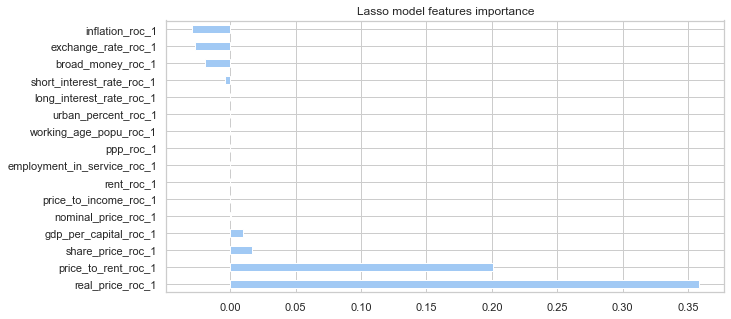

In [26]:
coefs = pd.DataFrame(
    data= [
        est.coef_ for est in cv_model["estimator"]
        ],
    columns=use_col
)
rank = coefs.mean().sort_values(ascending=False)
rank.plot(kind = "barh", figsize = (10, 5))
plt.title("Lasso model features importance")
plt.show()

- The above figure clearly show that `price_to_rent_roc_1`,  `share_price_roc_1`, `inflation_roc_1` having high correlation to the target variable

#### Baseline
- We simply use previous quarter price rate of change(one variable) to be the baseline model

In [27]:
df_test = df.iloc[-len(y_test):]
y_test =  df_test.real_price_roc
y_pred =  df_test.real_price_roc_1

In [28]:
# Model evaluation 
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.011055712047409365
10.63882733771601
0.38427321536866643


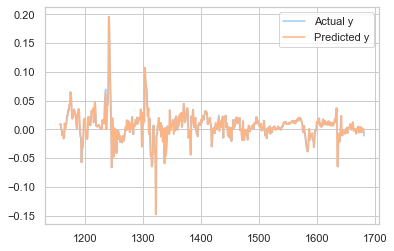

In [29]:
# Plot the prediction 
plt.clf()
plt.plot(y_test, label = "Actual y")
plt.plot(y_pred, label = "Predicted y")
plt.legend()
plt.show()

#### Comparing the model
- This is the summary for the model performance

| Model      | MAE | MAPE |R2|
| ----------- | ----------- | ----------- | ----------- |
| Lasso |0.0105  |8.02 |43.1%|
|Random Forest|0.0107|8.72|43.2%|
|Baseline (Lag(1))|0.0111|10.6|38.4%|

- As we can see in the table, our lasso and random forest model do little bit better than our baseline model
- However, the improvement may not be huge enough to use in the real life.
- After all, we may need to remove all the noise and cluster the data to get better performance in the model


